(HW7)=
# HW7

**Deadline (hard only!)**: 24.04.2024 11:59 (GMT+5).

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imread
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from glob import glob
%config InlineBackend.figure_format = 'svg'

def load_notmnist(path='./notMNIST_small',letters='ABCDEFGHIJ',
                  img_shape=(28,28),test_size=0.25,one_hot=False):

    # download data if it's missing. If you have any problems, go to the urls and load it manually.
    if not os.path.exists(path):
        print("Downloading data...")
        assert os.system('curl http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz > notMNIST_small.tar.gz') == 0
        print("Extracting ...")
        assert os.system('tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log') == 0

    data,labels = [],[]
    print("Parsing...")
    for img_path in glob(os.path.join(path,'*/*')):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters:
            continue
        try:
            data.append(resize(imread(img_path), img_shape))
            labels.append(class_i,)
        except:
            print("found broken img: %s [it's ok if <10 images are broken]" % img_path)

    data = np.stack(data)[:,None].astype('float32')
    data = (data - np.mean(data)) / np.std(data)

    #convert classes to ints
    letter_to_i = {l:i for i,l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))

    if one_hot:
        labels = (np.arange(np.max(labels) + 1)[None,:] == labels[:, None]).astype('float32')

    #split into train/test
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, stratify=labels)

    print("Done")
    return X_train, y_train, X_test, y_test

## Task description

In this notebook you are suggested to train several models of machine learning on the notMNIST dataset. To get full points per each model it must beat the **baseline** on test dataset. Models to test:

* logistic regression, 86% (**1 point**)
* k-nearest neigbors, 88% (**1 point**)
* MLP, 91% (**1 point**)
* CNN, 92% (**1.5 points**)
* overall comparison of models, including some graphs (e.g, bar plot) (**0.5 points**)

### Important notes

* The total time of execution of all cells must not exceed $10$ minutes
* Broken code in a section automatically implies $0$ points for this section
* Do not erase any existing cells
* Use magic cell %%time to measure the time of execution of heavy-computation cells
* For each model use the followind structure:
    1. Import and build model

    2. Fit model on train dataset

    3. Measure and print train and test accuracy

    4. Make predictions on test dataset

    5. Plot confusion matrix

    6. Plot 16 random samples from the test dataset with true labels and predicted classes
    
    7. Try different hyperparameters, plot graphs of accuracy vs most important parameters

## Load `notmnist` dataset

In [2]:
%%time
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Extracting ...
Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done
CPU times: user 10.3 s, sys: 931 ms, total: 11.3 s
Wall time: 15.1 s


Size of train and test datasets:

In [3]:
X_train.shape, X_test.shape

((14043, 784), (4681, 784))

Verify that the classes are balanced:

In [4]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1404, 1405, 1404, 1405, 1405, 1404, 1404, 1404, 1404, 1404]))

## Visualize some data

In [6]:
def plot_letters(X, y_true, y_pred=None, n=4, random_state=123):
    np.random.seed(random_state)
    indices = np.random.choice(np.arange(X.shape[0]), size=n*n, replace=False)
    plt.figure(figsize=(10, 10))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[indices[i]].reshape(28, 28), cmap='gray')
        # plt.imshow(train_images[i], cmap=plt.cm.binary)
        if y_pred is None:
            title = chr(ord("A") + y_true[indices[i]])
        else:
            title = f"y={chr(ord('A') + y_true[indices[i]])}, ŷ={chr(ord('A') + y_pred[indices[i]])}"
        plt.title(title, size=20)
    plt.show()

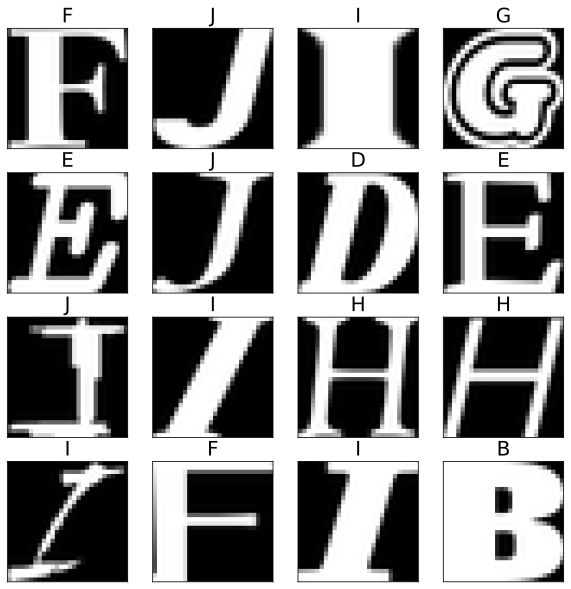

In [7]:
plot_letters(X_train, y_train, random_state=912)

## Logistic regression

**Hyperparameters**:
* regularization type (`penalty`)
* regularization constant ($C$)
* `max_iter`

In [90]:
%%time
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(penalty='l2', C=0.5, max_iter=1000)

logReg.fit(X_train, y_train)

lgy_pred = logReg.predict(X_test)

train_accuracy = accuracy_score(y_train, logReg.predict(X_train))

test_accuracy = accuracy_score(y_test, lgy_pred)

lR_accuracy = [round(train_accuracy*100, 2), round(test_accuracy*100, 2)]

print(f"Train accuracy: {lR_accuracy[0]}%")

print(f"Test accuracy: {lR_accuracy[1]}%")




Train accuracy: 97.27%
Test accuracy: 86.84%
CPU times: user 1min 9s, sys: 9.44 s, total: 1min 19s
Wall time: 1min 10s


##Plot confusion matrix

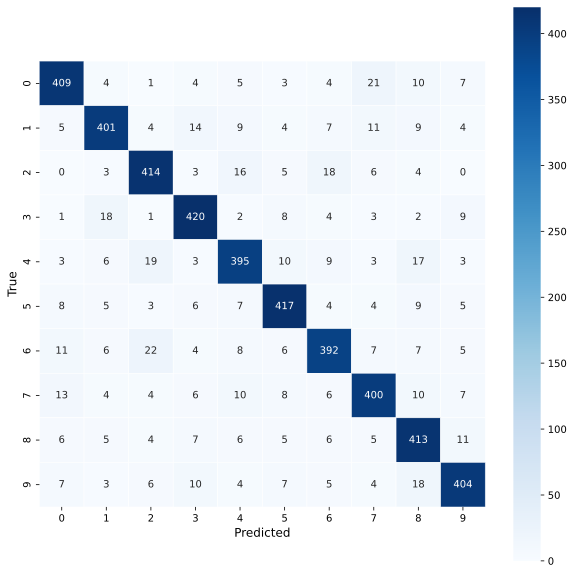

In [46]:
cm = confusion_matrix(y_test, lgy_pred)

plt.figure(figsize=(10,10))

sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');

plt.xlabel('Predicted', fontsize=12)

plt.ylabel('True', fontsize=12)

plt.show()


##Plot 16 random samples from the test dataset with true labels and predicted classes

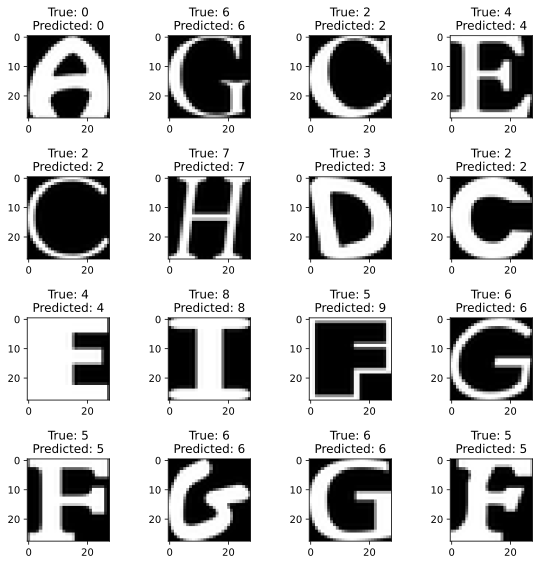

In [47]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):

    ax.imshow(X_test[i].reshape(28, 28), cmap=plt.cm.gray)

    ax.set_title(f'True: {y_test[i]}\nPredicted: {lgy_pred[i]}')

plt.tight_layout()

plt.show()

## kNN

**Hyperparameters**:
* `n_neigbors`
* `metric`

In [89]:
%%time
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski')

knn.fit(X_train, y_train)

knny_pred = knn.predict(X_test)

train_accuracy = accuracy_score(y_train, knn.predict(X_train))

test_accuracy = accuracy_score(y_test, knny_pred)
knn_accuracy = [round(train_accuracy*100, 2), round(test_accuracy*100, 2)]

print(f'Train accuracy: {knn_accuracy[0]}%')

print(f'Test accuracy: {knn_accuracy[1]}%')


Train accuracy: 91.58%
Test accuracy: 88.19%
CPU times: user 25.4 s, sys: 37.9 ms, total: 25.4 s
Wall time: 23.7 s


##Plot confusion matrix

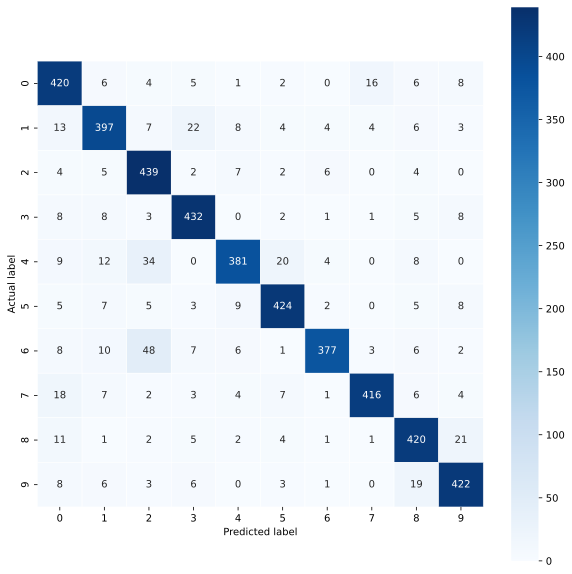

In [49]:
cm = confusion_matrix(y_test, knny_pred)

plt.figure(figsize=(10,10))

sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');

plt.ylabel('Actual label');

plt.xlabel('Predicted label');

##Plot 16 random samples from the test dataset with true labels and predicted classes

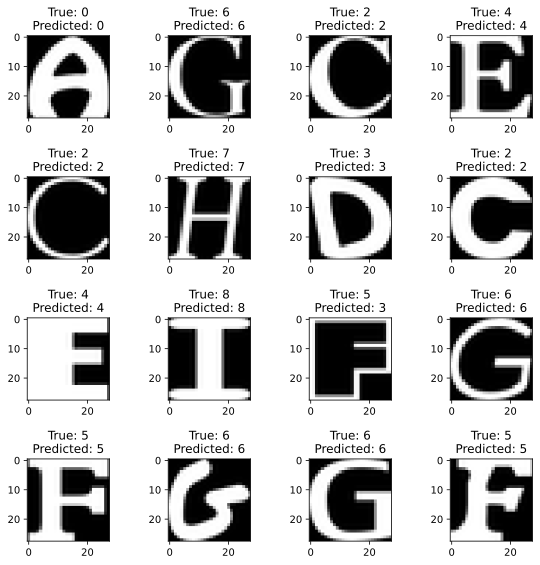

In [50]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):

    ax.imshow(X_test[i].reshape(28, 28), cmap=plt.cm.gray)

    ax.set_title(f'True: {y_test[i]}\nPredicted: {knny_pred[i]}')

plt.tight_layout()

plt.show()

## MLP

**Hyperparameters**:
* number of layers
* width of layers
* activation function

In [91]:
%%time
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=200)

mlp.fit(X_train, y_train)

mlpy_pred = mlp.predict(X_test)

train_accuracy = accuracy_score(y_train, mlp.predict(X_train))

test_accuracy = accuracy_score(y_test, mlpy_pred)

mlp_accuracy = [round(train_accuracy*100, 2), round(test_accuracy*100, 2)]

print(f'Train accuracy: {mlp_accuracy[0]}%')

print(f'Test accuracy: {mlp_accuracy[1]}%')




Train accuracy: 99.94%
Test accuracy: 91.99%
CPU times: user 30.3 s, sys: 12.6 s, total: 42.9 s
Wall time: 24.8 s


##Plot confusion matrix

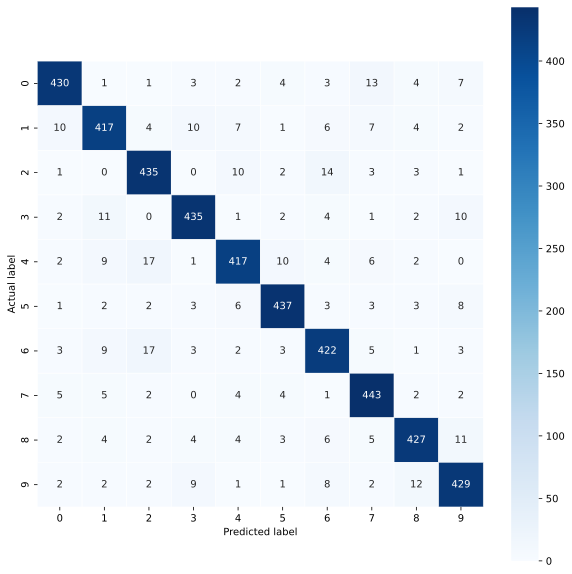

In [55]:
cm = confusion_matrix(y_test, mlpy_pred)

plt.figure(figsize=(10,10))

sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');

plt.ylabel('Actual label');

plt.xlabel('Predicted label');

##Plot 16 random samples from the test dataset with true labels and predicted classes

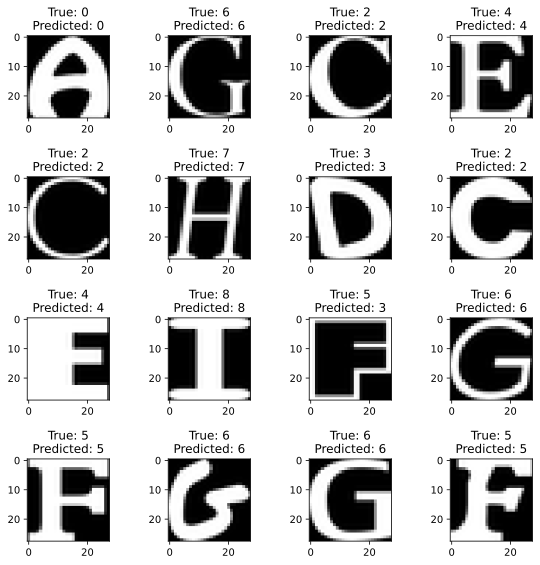

In [56]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):

    ax.imshow(X_test[i].reshape(28, 28), cmap=plt.cm.gray)

    ax.set_title(f'True: {y_test[i]}\nPredicted: {mlpy_pred[i]}')

plt.tight_layout()

plt.show()

## CNN

**Hyperparameters**:
* number of convolutional layers
* number of dense layers
* activation function

In [85]:
%%time
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.utils import to_categorical

X_train_cnn = X_train.reshape(-1,28,28,1)

X_test_cnn = X_test.reshape(-1,28,28,1)


y_train_cnn = to_categorical(y_train)

y_test_cnn = to_categorical(y_test)


model = Sequential()


model.add(Conv2D(64, kernel_size=4, activation='relu', input_shape=(28,28,1)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=4, activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(10, activation='softmax'))



model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


y_pred_prob = model.predict(X_test_cnn)

cnny_pred = np.argmax(y_pred_prob, axis=-1)


model.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=16)


train_accuracy = model.evaluate(X_train_cnn, y_train_cnn)[1]

test_accuracy = model.evaluate(X_test_cnn, y_test_cnn)[1]


print(f'Train accuracy: {train_accuracy*100:.2f}%')

print(f'Test accuracy: {test_accuracy*100:.2f}%')

147/147 [==============================] - 2s 15ms/step
Epoch 1/16
439/439 [==============================] - 20s 44ms/step - loss: 0.7304 - accuracy: 0.7709 - val_loss: 0.4981 - val_accuracy: 0.8481
Epoch 2/16
439/439 [==============================] - 18s 41ms/step - loss: 0.4284 - accuracy: 0.8708 - val_loss: 0.4170 - val_accuracy: 0.8729
Epoch 3/16
439/439 [==============================] - 20s 45ms/step - loss: 0.3538 - accuracy: 0.8882 - val_loss: 0.3958 - val_accuracy: 0.8857
Epoch 4/16
439/439 [==============================] - 21s 49ms/step - loss: 0.3142 - accuracy: 0.9018 - val_loss: 0.3762 - val_accuracy: 0.8844
Epoch 5/16
439/439 [==============================] - 19s 44ms/step - loss: 0.2844 - accuracy: 0.9112 - val_loss: 0.3859 - val_accuracy: 0.8836
Epoch 6/16
439/439 [==============================] - 18s 41ms/step - loss: 0.2585 - accuracy: 0.9187 - val_loss: 0.3672 - val_accuracy: 0.8947
Epoch 7/16
439/439 [==============================] - 19s 44ms/step - loss: 0.23

Plot confusion matrix

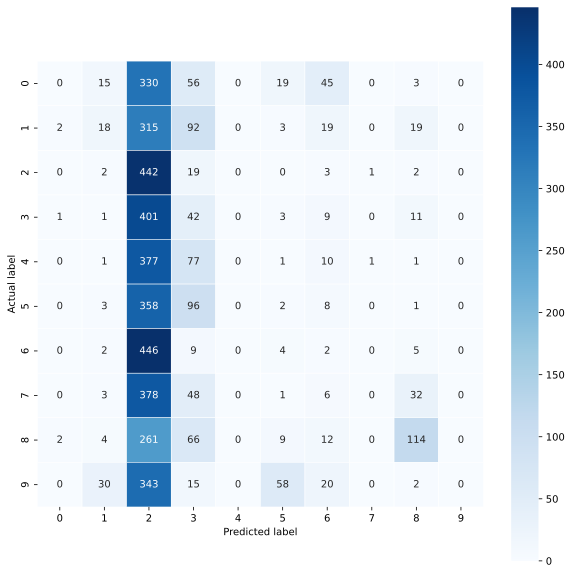

In [83]:
cm = confusion_matrix(y_test, cnny_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

##Plot 16 random samples from the test dataset with true labels and predicted classes

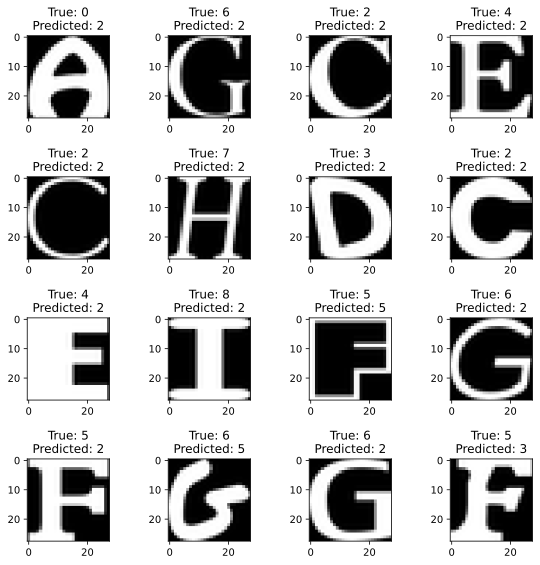

In [84]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):

    ax.imshow(X_test[i].reshape(28, 28), cmap=plt.cm.gray)

    ax.set_title(f'True: {y_test[i]}\nPredicted: {cnny_pred[i]}')

plt.tight_layout()

plt.show()

## Plot results

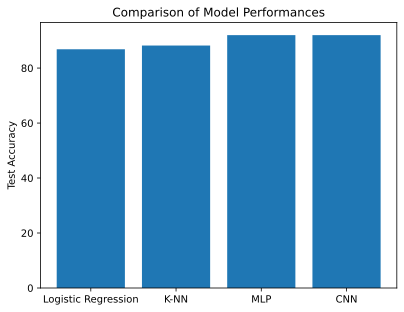

In [94]:
import matplotlib.pyplot as plt

accuracies = [lR_accuracy[1], knn_accuracy[1], mlp_accuracy[1], round(test_accuracy*100, 2)]

models = ['Logistic Regression', 'K-NN', 'MLP', 'CNN']

plt.bar(models, accuracies)
plt.ylabel('Test Accuracy')
plt.title('Comparison of Model Performances')
plt.show()